In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d

from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

from numba import jit, float64, int64

In [2]:
@jit(nopython=True)
def simulate_CDDM(threshold, lamda, delta, ndt=0, z=0, sigma=1, dt=0.001):
    x = z
    
    rt = 0
    
    while -(threshold * np.exp(-lamda*rt)) < x and x < (threshold * np.exp(-lamda*rt)):
        x += delta * dt + sigma*np.sqrt(dt)*np.random.normal(0, 1)
        rt += dt
        
    if x >= (threshold * np.exp(-lamda*rt)):
        ch = 1
    else:
        ch = -1
        
    return (rt+ndt)*ch

In [3]:
@jit(nopython=True)
def f(x, t, z, tau, delta, sigma=1):
    term1 = 1/np.sqrt(2 * np.pi * sigma**2 * (t-tau))
    term2 = -(x - z - delta * (t-tau))**2 / (2 * sigma**2 * (t-tau))
    return term1 * np.exp(term2)

@jit(nopython=True)
def psi(threshold, lamda, t, z, tau, delta, sigma=1):
    db = -lamda * threshold * np.exp(-lamda*t)
    term1 = 0.5*f(threshold * np.exp(-lamda*t), t, z, tau, delta, sigma)
    term2 = db - delta - (threshold * np.exp(-lamda*t) - z - delta * (t-tau))/(t-tau)
    return term1 * term2

@jit(nopython=True)
def fpt(threshold, lamda, delta, z=0, sigma=1, dt=0.02, T_max=5):
    gu = np.zeros((int(T_max/dt)+2,))
    gl = np.zeros((int(T_max/dt)+2,))
    T = np.zeros((int(T_max/dt)+2,))
    
    gu[1] = -2*psi(threshold, lamda, dt, z, 0, delta, sigma)
    gl[1] =  2*psi(-threshold, lamda, dt, z, 0, delta, sigma)
    T[1] = dt
    
    for n in range(2, int(T_max/dt)+2):
        su = -2 * psi( threshold, lamda, n*dt, z, 0, delta, sigma)
        sl =  2 * psi(-threshold, lamda, n*dt, z, 0, delta, sigma)
        
        for j in range(1, n):
            if threshold * np.exp(-lamda*j*dt) == 0:
                continue
            
            psi_n_j_pp = psi( threshold, lamda, n*dt,  threshold * np.exp(-lamda*j*dt), j*dt, delta, sigma)
            psi_n_j_pn = psi( threshold, lamda, n*dt, -threshold * np.exp(-lamda*j*dt), j*dt, delta, sigma)
            psi_n_j_np = psi(-threshold, lamda, n*dt,  threshold * np.exp(-lamda*j*dt), j*dt, delta, sigma)
            psi_n_j_nn = psi(-threshold, lamda, n*dt, -threshold * np.exp(-lamda*j*dt), j*dt, delta, sigma)
            
            su +=  2 * dt * (gu[j] * psi_n_j_pp + gl[j] * psi_n_j_pn)
            sl += -2 * dt * (gu[j] * psi_n_j_np + gl[j] * psi_n_j_nn)
            
        gu[n] = su
        gl[n] = sl
        T[n] = (n*dt)
    return gu, gl, T

In [4]:
def CDDM_likelihood(prms, RT, dummy):
#     ub = lambda t: prms[0] * np.exp(-prms[1]*t)
#     lb = lambda t: -1*ub(t)
#     dub = lambda t: -prms[1] * prms[0] * np.exp(-prms[1]*t)
#     dlb = lambda t: -1*dub(t)

    delta = prms[2]
    t0 = prms[3]
    
    T_max = np.max(np.abs(RT))
    gu, gl, TT = fpt(prms[0], prms[1], delta, z=0, dt=0.02, T_max=T_max)
    
    gtup = interp1d(TT, gu)
    gtlp = interp1d(TT, gl)
    
    ll = 0
    for i in range(len(RT)):
        if np.abs(RT[i])-t0 > 0:
            if RT[i]>=0:
                
                if gtup(RT[i])>1e-14:
                    ll += -np.log(gtup(np.abs(RT[i])-t0))
                else:
                    ll += -np.log(1e-14)
            else:
                
                if gtlp(np.abs(RT[i])-t0)>1e-14:
                    ll += -np.log(gtlp(np.abs(RT[i])-t0))
                else:
                    ll += -np.log(1e-14) 
        else:
            ll += -np.log(1e-14)
    
    return ll

In [5]:
n_trials = 1000
recovery_dic = {'a_true': [],
                'a_estimate': [],
                'lambda_true': [],
                'lambda_estimate': [],
                'delta_true': [],
                'delta_estimate': [],
                'ndt_true':[],
                'ndt_estimate':[]}

In [6]:
for n in tqdm(range(800)):
    threshold = np.random.uniform(1.5, 4)
    lamda = np.random.uniform(0.1, 2)
    delta = np.random.uniform(0, 3)
    ndt = np.random.uniform(0.05, 1)
    
#     ub = lambda t: threshold * np.exp(-lamda*t)
#     lb = lambda t: -1*ub(t)
    
    RT = []
    
    for i in range(n_trials):
        rt = simulate_CDDM(threshold, lamda, delta, ndt=ndt)
        RT.append(rt)
        
    RT = np.array(RT)
    
    ans_cddm = differential_evolution(CDDM_likelihood,
                                      args=(RT, None), 
                                      bounds=[(1.5, 4), (0.1, 2),
                                              (0, 3), (0.05, 1)])
    ans_cddm = minimize(CDDM_likelihood,
                        args=(RT, None),
                        method='Nelder-Mead',
                        x0=ans_cddm.x,
                        bounds=[(1.5, 4), (0.1, 2), 
                                (0, 3), (0.05, 1)])    
    
    recovery_dic['a_true'].append(threshold)
    recovery_dic['a_estimate'].append(ans_cddm.x[0])
    recovery_dic['lambda_true'].append(lamda)
    recovery_dic['lambda_estimate'].append(ans_cddm.x[1])
    recovery_dic['delta_true'].append(delta)
    recovery_dic['delta_estimate'].append(ans_cddm.x[2])
    recovery_dic['ndt_true'].append(ndt)
    recovery_dic['ndt_estimate'].append(ans_cddm.x[3])

100%|███████████████████████████████████████████████| 800/800 [6:50:45<00:00, 30.81s/it]


In [7]:
recovery_df = pd.DataFrame(recovery_dic)

In [8]:
file_name = '_data/Exponential_rec_{}.csv'.format(n_trials)
old_recovery_data = pd.read_csv(file_name, index_col=0)
recovery_df = pd.concat([old_recovery_data, 
                         recovery_df]).reset_index(drop=True)
recovery_df.to_csv(file_name)

In [9]:
print(recovery_df.shape)
recovery_df.corr()

(1000, 8)


,a_true,a_estimate,lambda_true,lambda_estimate,delta_true,delta_estimate,ndt_true,ndt_estimate
a_true,1.000000,0.775085,0.012737,-0.033176,-0.087343,-0.069165,-0.056485,0.007688
a_estimate,0.775085,1.000000,-0.087563,0.003571,-0.037092,-0.051804,0.021347,-0.047020
lambda_true,0.012737,-0.087563,1.000000,0.964466,0.005570,-0.000045,-0.030098,-0.015688
lambda_estimate,-0.033176,0.003571,0.964466,1.000000,-0.001597,-0.033265,-0.004382,-0.025322
delta_true,-0.087343,-0.037092,0.005570,-0.001597,1.000000,0.990384,0.008181,-0.011101
delta_estimate,-0.069165,-0.051804,-0.000045,-0.033265,0.990384,1.000000,0.000573,-0.010275
ndt_true,-0.056485,0.021347,-0.030098,-0.004382,0.008181,0.000573,1.000000,0.976210
ndt_estimate,0.007688,-0.047020,-0.015688,-0.025322,-0.011101,-0.010275,0.976210,1.000000


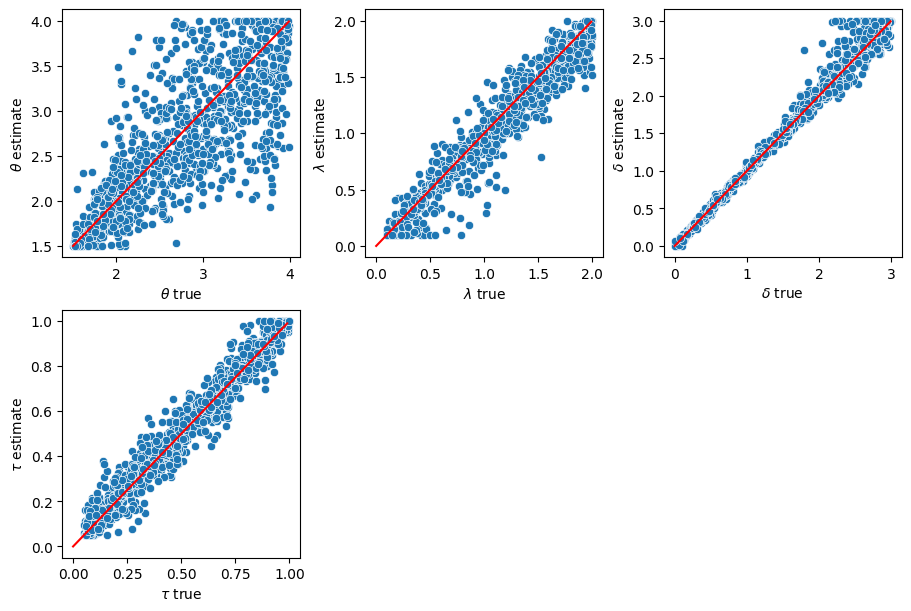

In [10]:
plt.figure(figsize=(9, 6), layout='constrained')

plt.subplot(231)
plt.plot(np.arange(1.5, 4, 0.01), np.arange(1.5, 4, 0.01), c='red')
sns.scatterplot(x='a_true', y='a_estimate', data=recovery_df);
plt.xlabel(r'$\theta$ true')
plt.ylabel(r'$\theta$ estimate')

plt.subplot(232)
plt.plot(np.arange(0, 2, 0.01), np.arange(0, 2, 0.01), c='red')
sns.scatterplot(x='lambda_true', y='lambda_estimate', data=recovery_df);
plt.xlabel(r'$\lambda$ true')
plt.ylabel(r'$\lambda$ estimate')

plt.subplot(233)
plt.plot(np.arange(0, 3, 0.01), np.arange(0, 3, 0.01), c='red')
sns.scatterplot(x='delta_true', y='delta_estimate', data=recovery_df);
plt.xlabel(r'$\delta$ true')
plt.ylabel(r'$\delta$ estimate')

plt.subplot(234)
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), c='red')
sns.scatterplot(x='ndt_true', y='ndt_estimate', data=recovery_df);
plt.xlabel(r'$\tau$ true')
plt.ylabel(r'$\tau$ estimate');